# Ideal Parameter Analysis ($\delta=1$, $\tau=0.75$, $\alpha=1.75$) ($\delta$ lower bound, $\tau$ lower bound, $\alpha$ lower bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1
expected_tau=0.75
expected_alpha=1.75

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

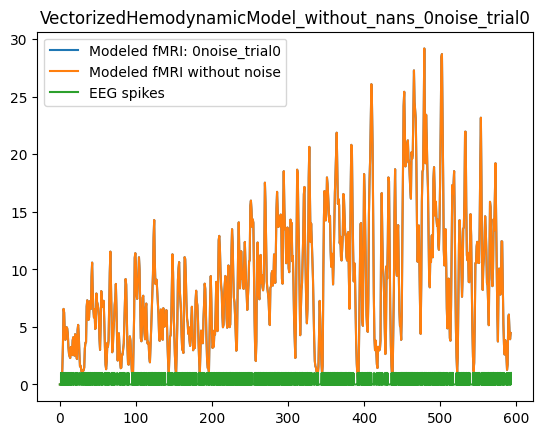

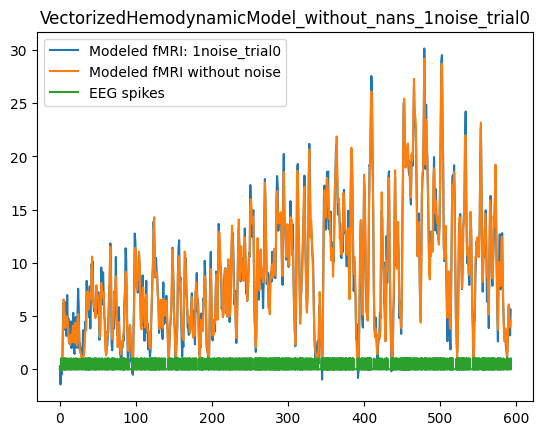

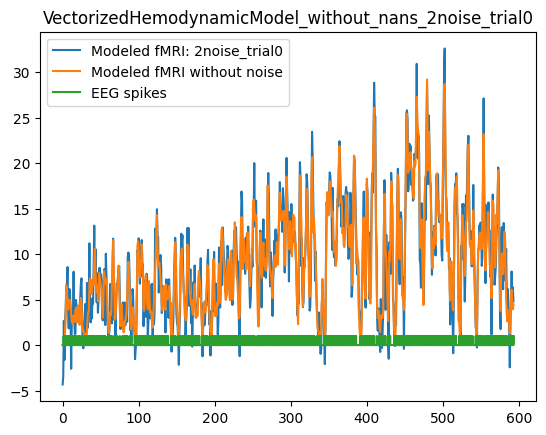

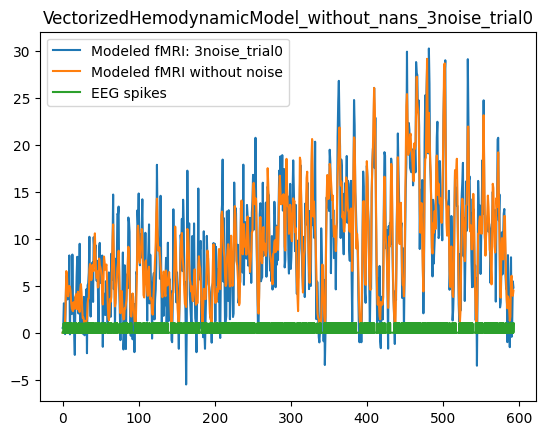

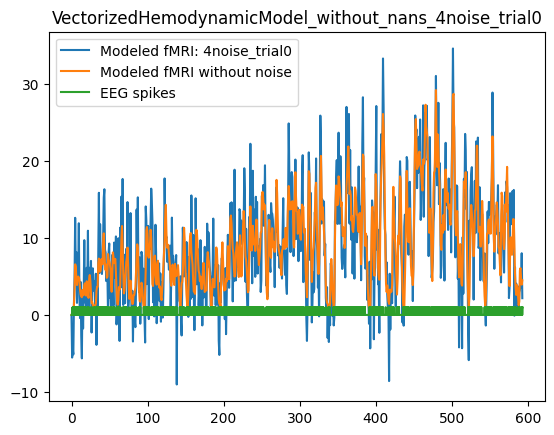

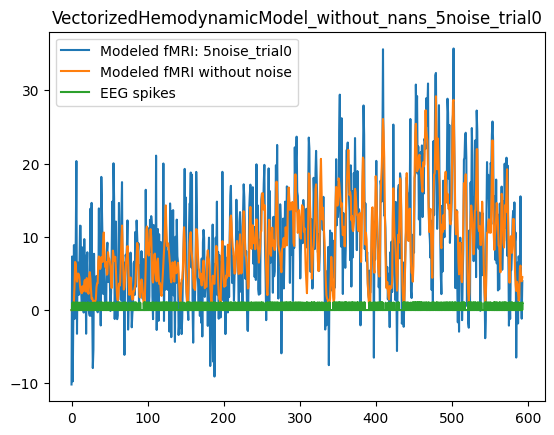

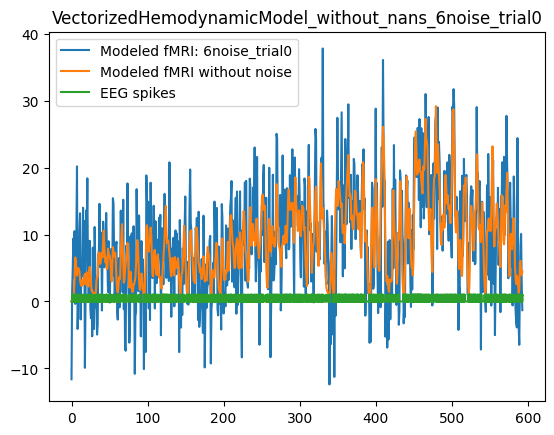

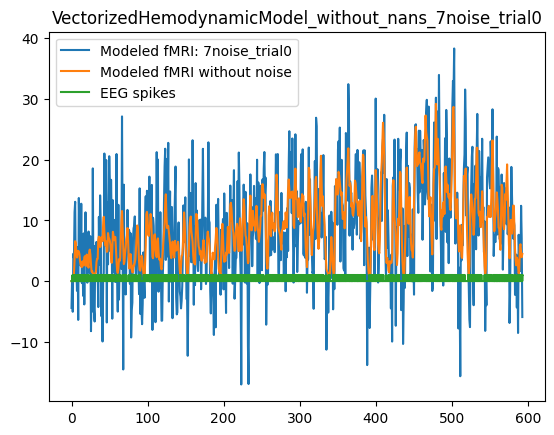

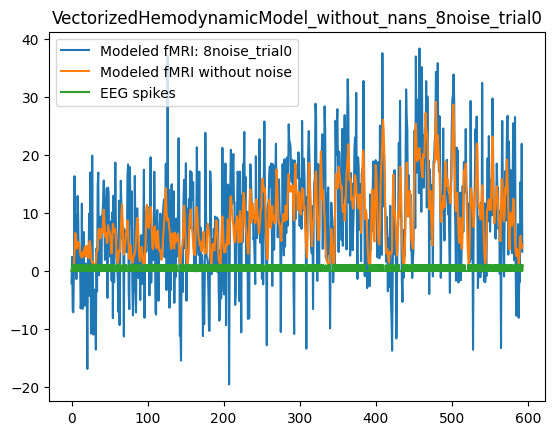

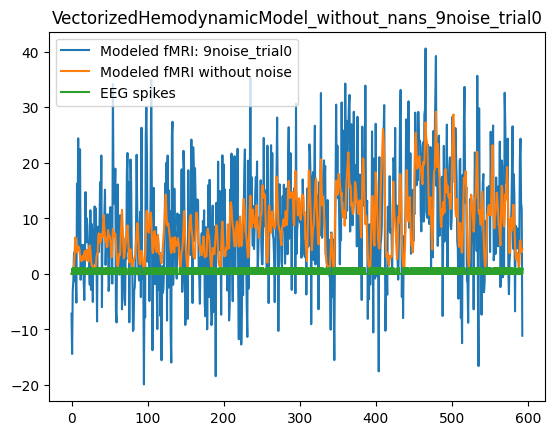

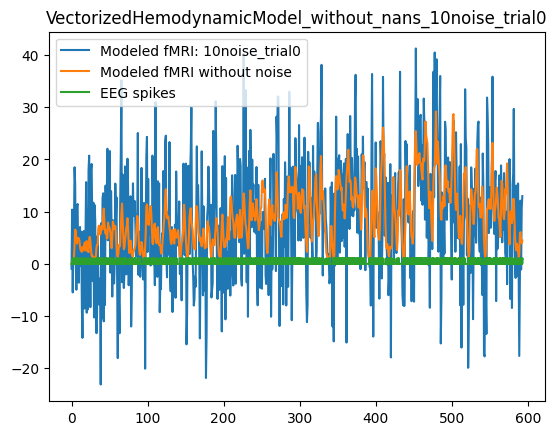

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 0.75, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 1.75, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1, tau=0.75, alpha=1.75


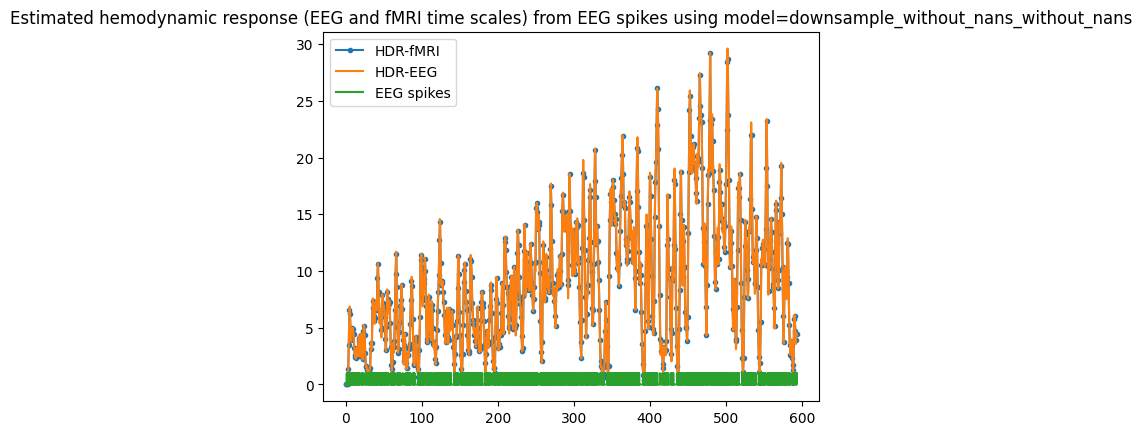

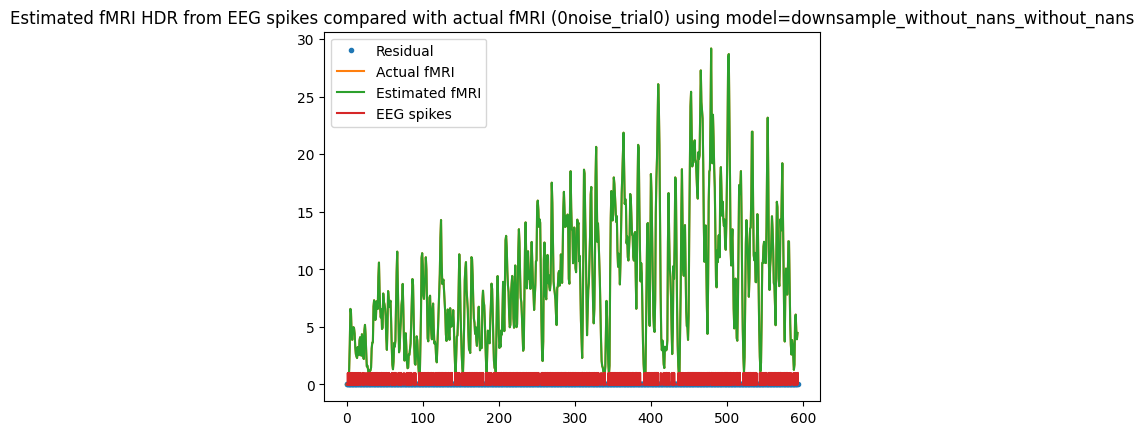

Residual Variance is 0.000000


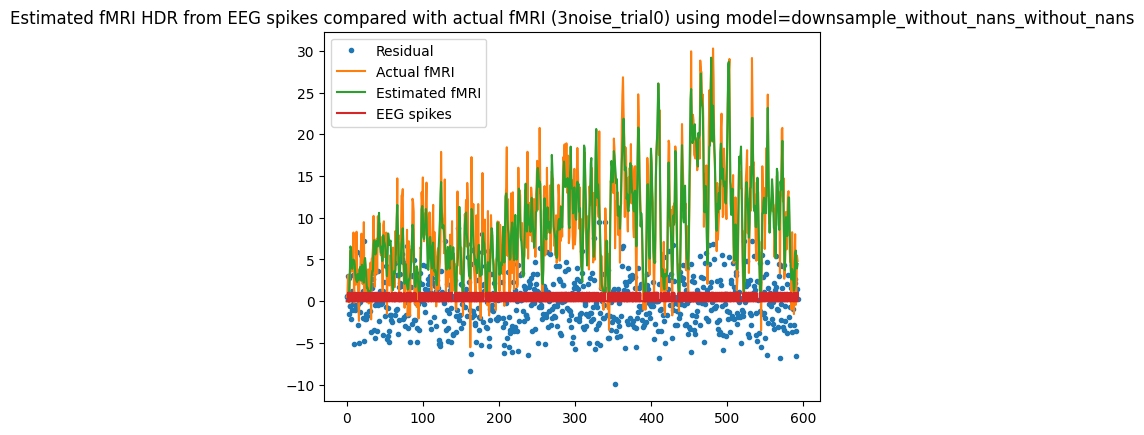

Residual Variance is 9.348892


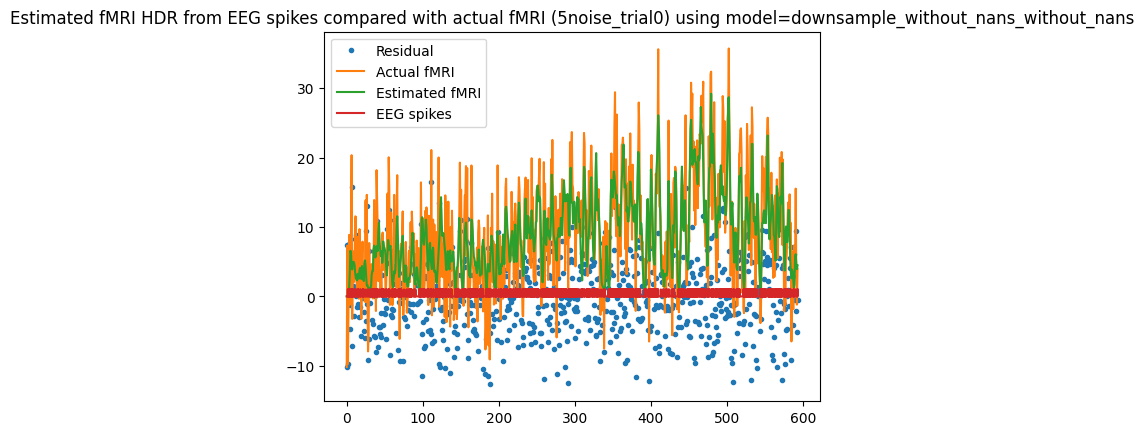

Residual Variance is 27.233586


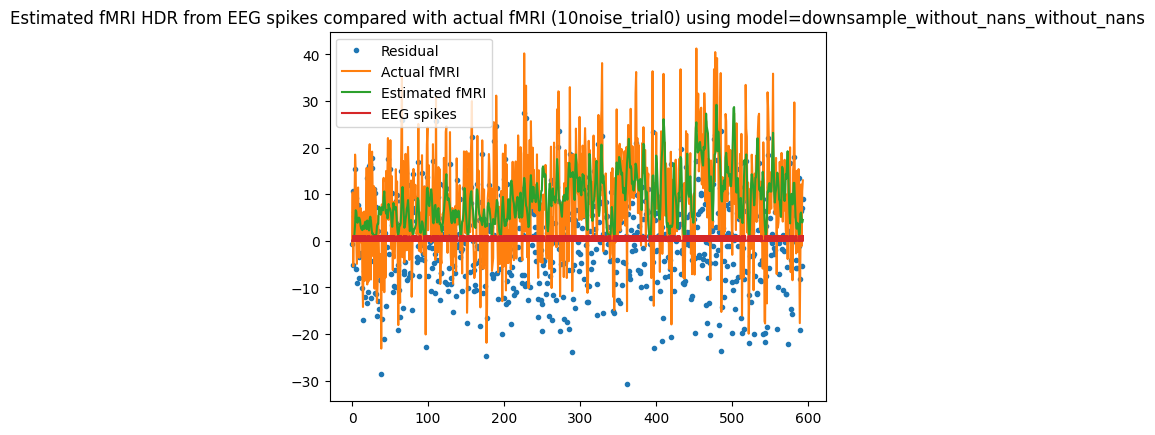

Residual Variance is 97.922095


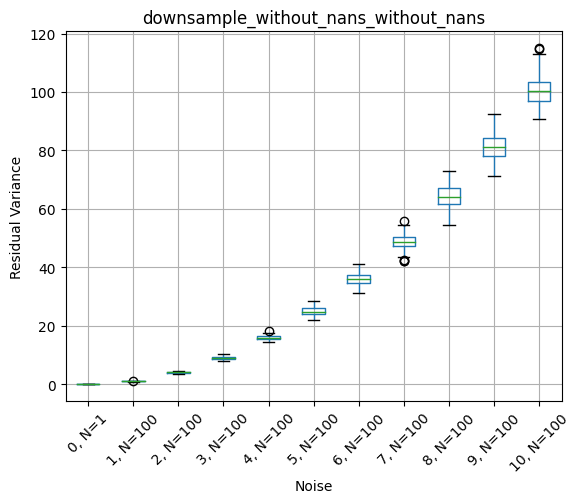

Scoring downsample_without_nans_with_nans delta=1, tau=0.75, alpha=1.75


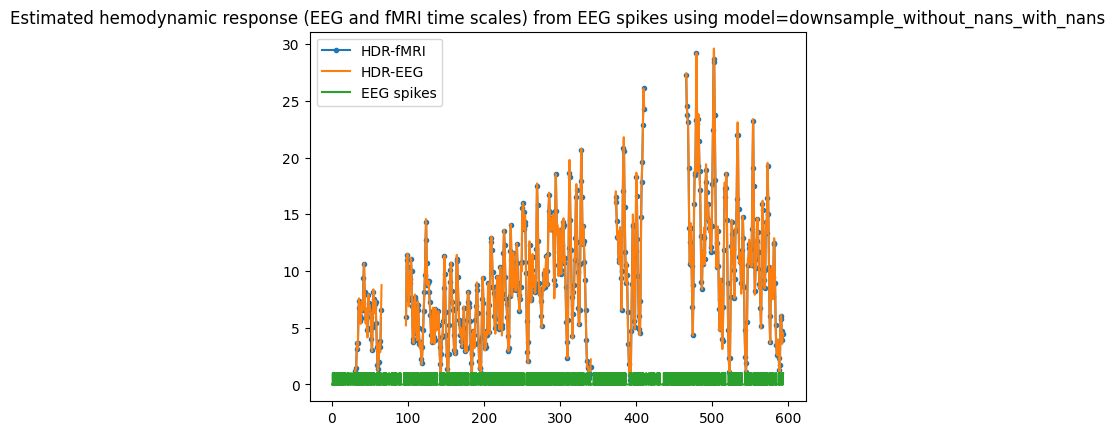

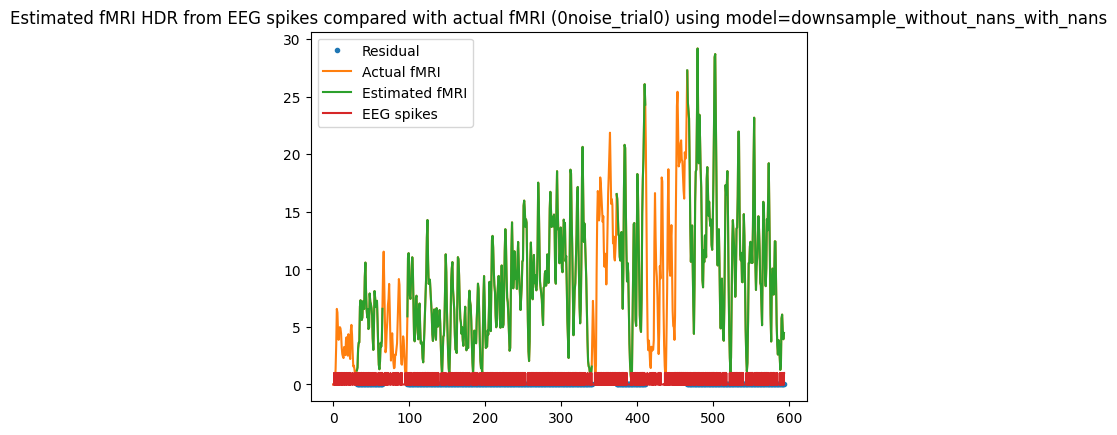

Residual Variance is 0.000000


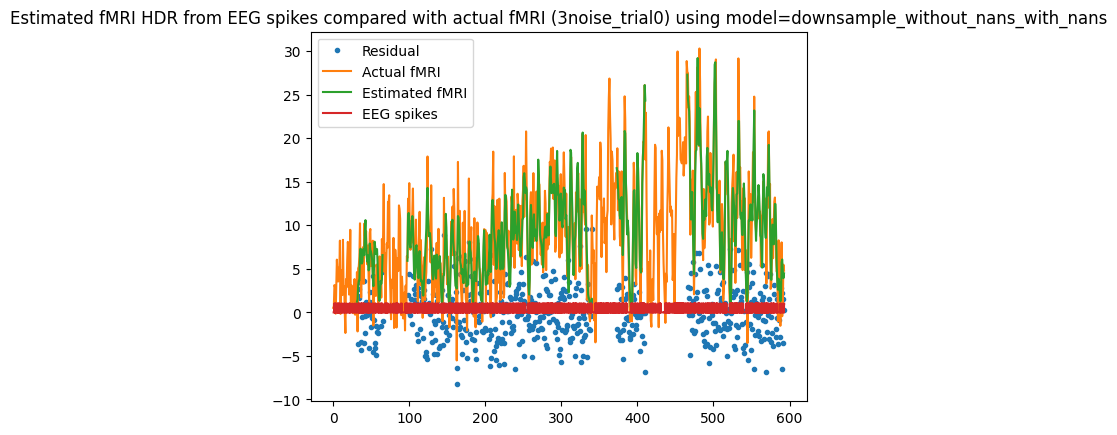

Residual Variance is 9.469861


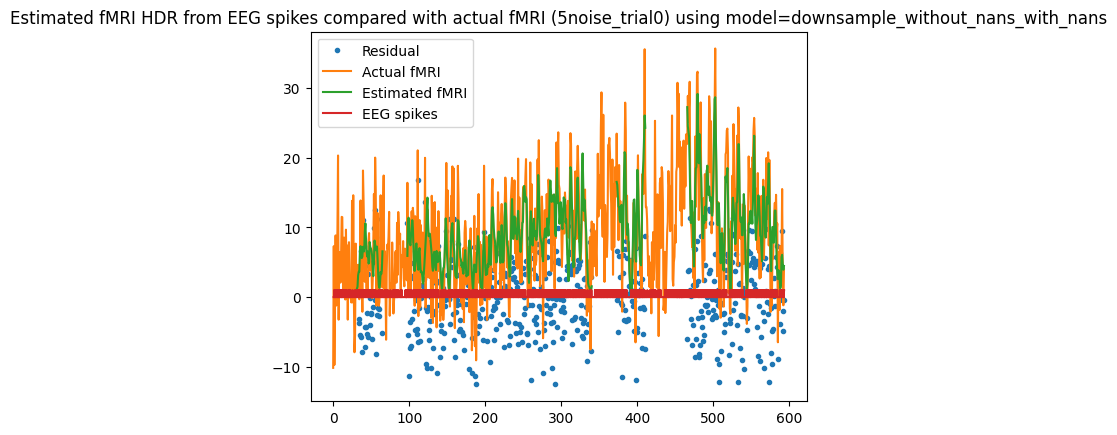

Residual Variance is 27.868292


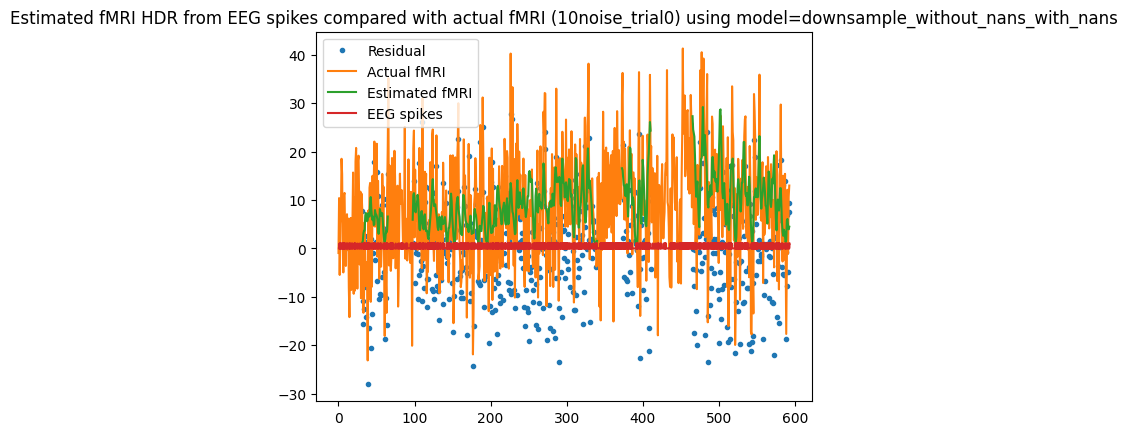

Residual Variance is 101.738930


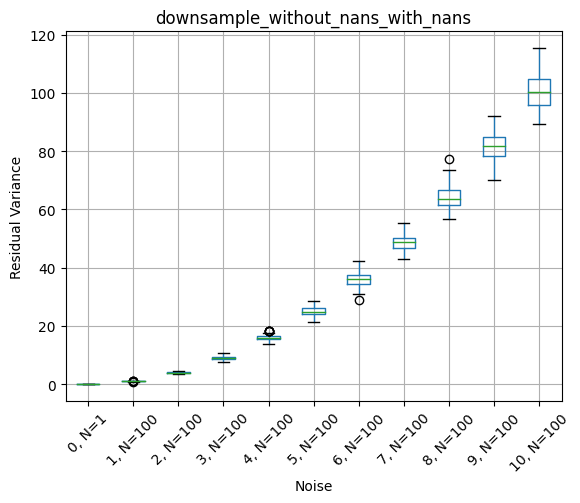

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name           0noise_trial0  \
0      downsample_without_nans_without_nans  1.6034605628447425e-30   
1         downsample_without_nans_with_nans   2.912543246681353e-29   
2      downsample_without_nans_without_nans    0.011439458258821044   
3         downsample_without_nans_with_nans    0.011552017555784076   
4      downsample_without_nans_without_nans      0.0451789673744971   
...                                     ...                     ...   
18937     downsample_without_nans_with_nans      22.667634003155428   
18938  downsample_without_nans_without_nans      24.115419964462447   
18939     downsample_without_nans_with_nans      22.717087194758484   
18940  downsample_without_nans_without_nans       24.18307547708766   
18941     downsample_without_nans_with_nans      22.762377133643405   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      1.0396133834844037      4.154409715466   9.348891507499625   
1      0.9951562301272365   4.172097352345656   9.469860908056592   
2       1.048263495388057   4.131097308014953   9.377420725160341   
3      0.9957093093739301   4.151376409675095   9.489589469828237   
4      1.0793668145483917   4.132366519526697   9.427562877814799   
...                   ...                 ...                 ...   
18937  23.693826601454298  27.569557906085084  31.791202185179067   
18938  25.063095892334456    29.3357680851604   33.42928805079335   
18939   23.74425175207128   27.62844525835035  31.846665362540058   
18940  25.130974850105083  29.414694256059363   33.49509610559012   
18941  23.790436233995614  27.682805116963042   31.89782218880897   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       15.43445961544364   27.23358623571832  ...  0.9409491273999533   
1       15.46006787719196   27.86829236895388  ...   0.979568438089984   
2       15.46904280014356   27.27008007868886  ...  0.9721280254465119   
3       15.48572676176056  27.943505600539183  ...   1.017335823396959   
4      15.527040169394855  27.330018709029385  ...   1.025241416886764   
...                   ...                 ...  ...                 ...   
18937   40.18885658863851   53.89447619327378  ...   23.60577035810973   
18938   41.43555889446445   53.86846610961789  ...  25.061799364384466   
18939   40.25110287350969   53.92243435137756  ...   23.64768826430935   
18940   41.51612385036002   53.91419837702833  ...   25.12287879144626   
18941  40.309529960191945   53.94512327134726  ...  23.685622113924094   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       3.577787921681857   8.348894886561418   15.42394316040426   
1      3.6392340589250303   8.571235267511616   15.42123445198281   
2      3.6044102695170284    8.36263996883094   15.50574939161117   
3       3.666119378435316   8.555589409566897  15.511351317203964   
4      3.6531934562555235   8.399313675518982   15.60958248596923   
...                   ...                 ...                 ...   
18937   26.57705123102117  31.365914488112626  41.866169029073504   
18938  28.570251649636205    32.1879996955615   42.23758137664113   

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.6034605628447425e-30; at
   delta   tau  alpha
0    1.0  0.75   1.75


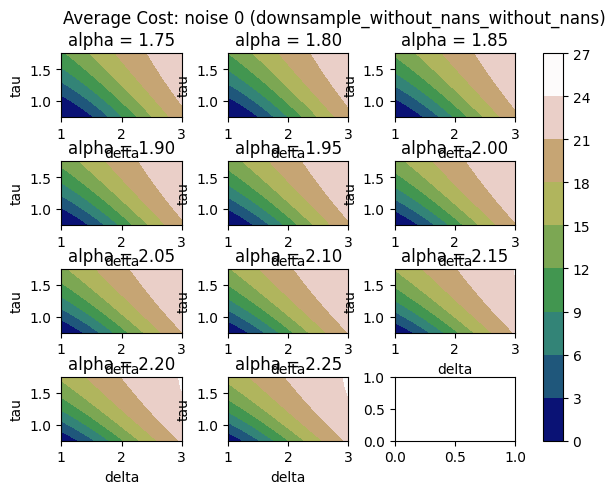

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                           1.603461e-30             
2                                           1.143946e-02             
4                                           4.517897e-02             
6                                           1.003463e-01             
8                                           1.760660e-01             
...                                                  ...             
18932                                       2.388284e+01             
18934                                       2.396551e+01             
18936                                       2.404297e+01             
18938                                       2.411542e+01             
18940                                       2.418308e+01             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 0.75, Alpha target: 1.75


delta   tau  alpha
0    1.0  0.75   1.75

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 0.75, Alpha target: 1.75


noise iteration          cost  delta   tau  alpha
0      0         0  1.603461e-30    1.0  0.75   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  1.603461e-30    1.0  0.75   1.75

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration          cost  delta   tau  alpha
0      0         0  1.603461e-30    1.0  0.75   1.75

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration          cost  delta   tau  alpha
0      0         0  1.603461e-30    1.0  0.75   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.912543246681353e-29; at
   delta   tau  alpha
1    1.0  0.75   1.75


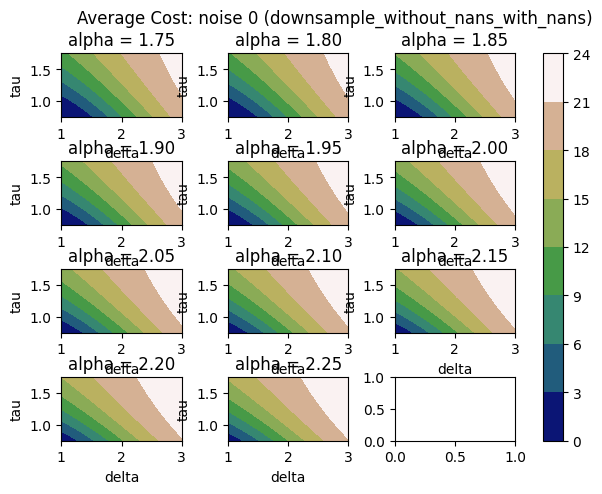

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                           2.912543e-29          
3                                           1.155202e-02          
5                                           4.560639e-02          
7                                           1.012585e-01          
9                                           1.776030e-01          
...                                                  ...          
18933                                       2.255544e+01          
18935                                       2.261382e+01          
18937                                       2.266763e+01          
18939                                       2.271709e+01          
18941                                       2.276238e+01          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 0.75, Alpha target: 1.75


delta   tau  alpha
0    1.0  0.75   1.75

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 0.75, Alpha target: 1.75


noise iteration          cost  delta   tau  alpha
0      0         0  2.912543e-29    1.0  0.75   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         1.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  2.912543e-29    1.0  0.75   1.75

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration          cost  delta   tau  alpha
0      0         0  2.912543e-29    1.0  0.75   1.75

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration          cost  delta   tau  alpha
0      0         0  2.912543e-29    1.0  0.75   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0100443077102954; at
   delta   tau  alpha
0    1.0  0.75   1.75


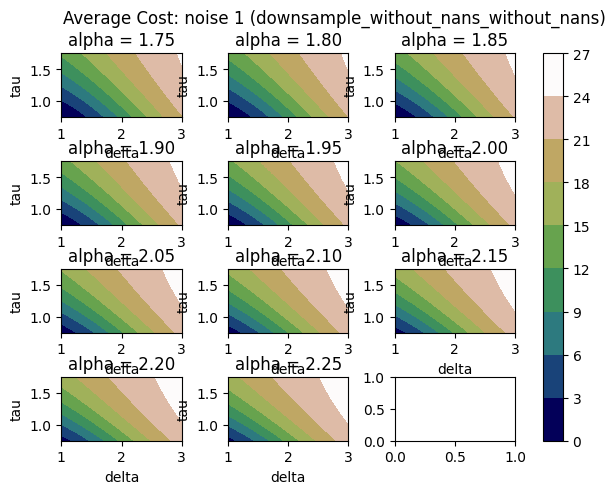

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.998728119886859; at
   delta   tau  alpha
0    1.0  0.75   1.75


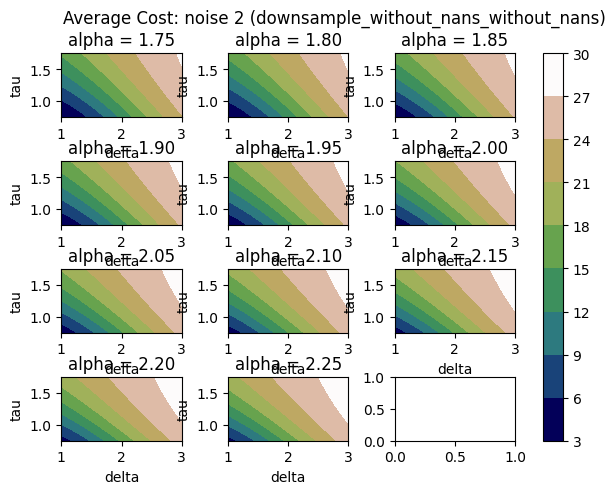

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.080420697969917; at
   delta   tau  alpha
0    1.0  0.75   1.75


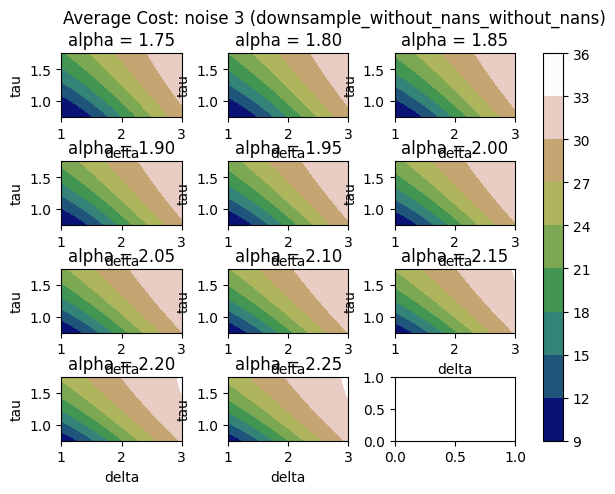

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.895405498728437; at
   delta   tau  alpha
0    1.0  0.75   1.75


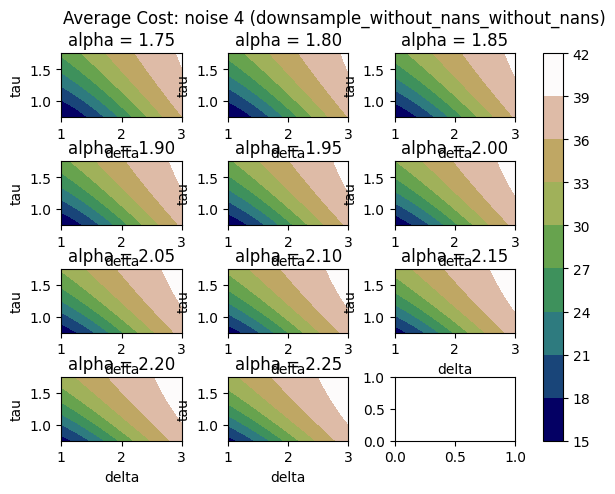

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.007520278507222; at
   delta   tau  alpha
0    1.0  0.75   1.75


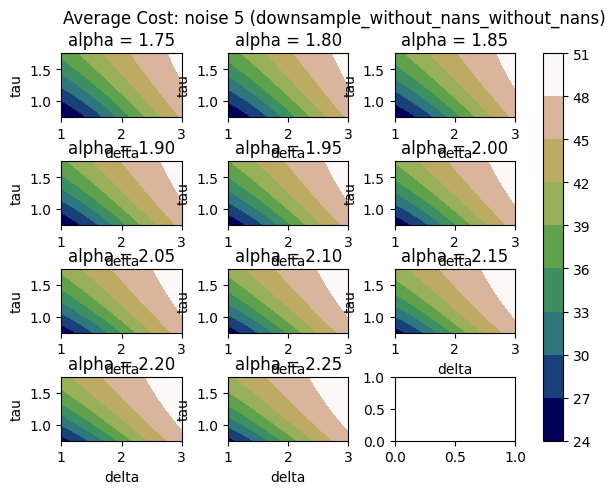

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.89351618965868; at
   delta   tau  alpha
0    1.0  0.75   1.75


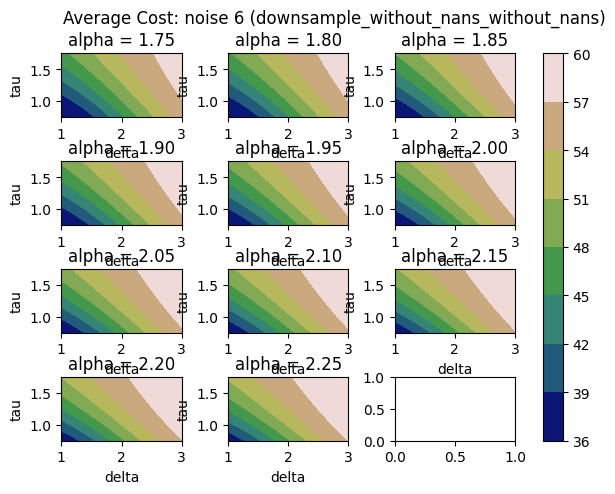

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.698527898011555; at
   delta   tau  alpha
0    1.0  0.75   1.75


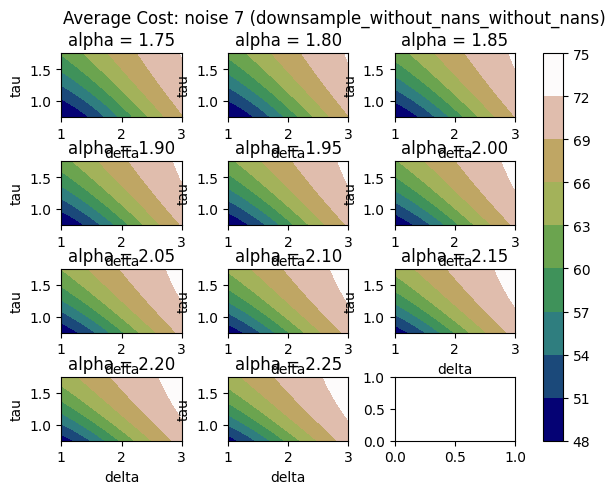

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.29339453189797; at
   delta   tau  alpha
0    1.0  0.75   1.75


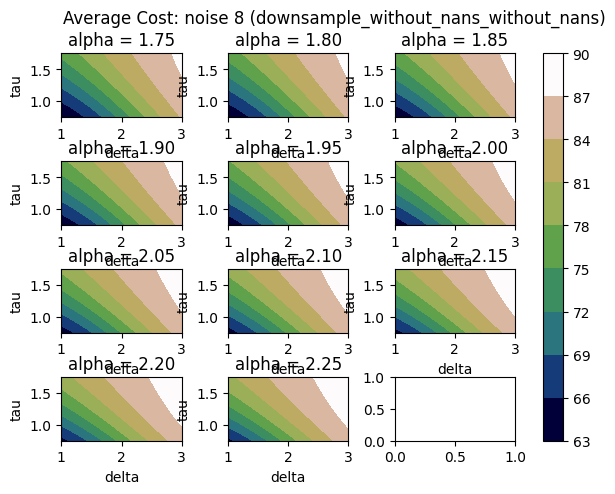

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.124325617482; at
   delta   tau  alpha
0    1.0  0.75   1.75


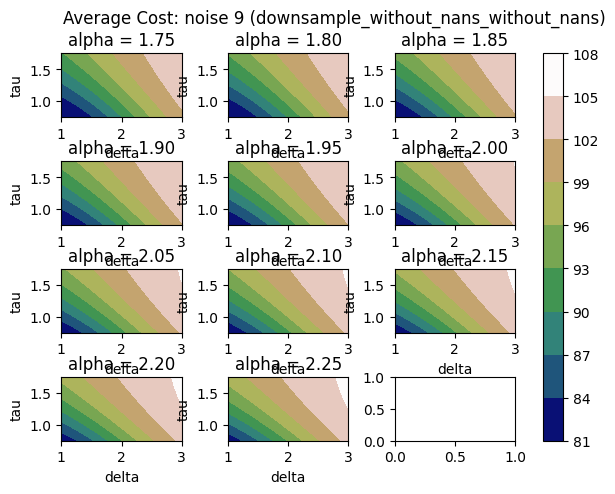

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.55755256425653; at
   delta   tau  alpha
0    1.0  0.75   1.75


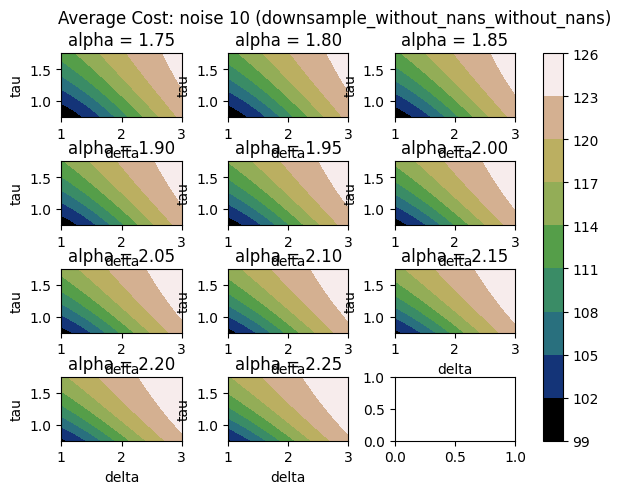

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

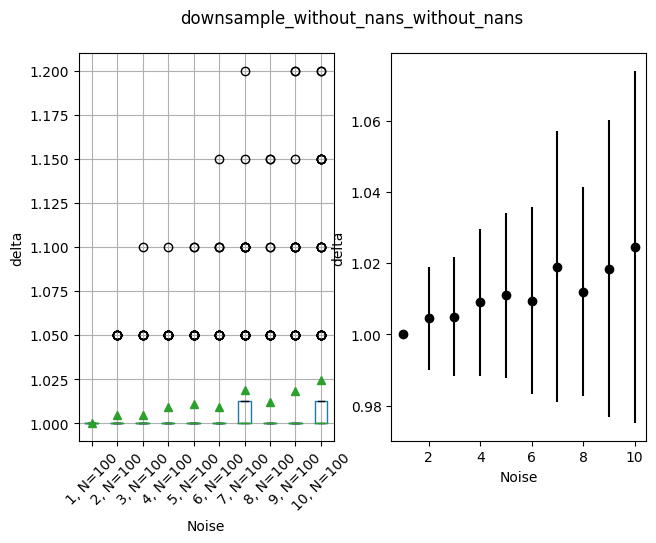

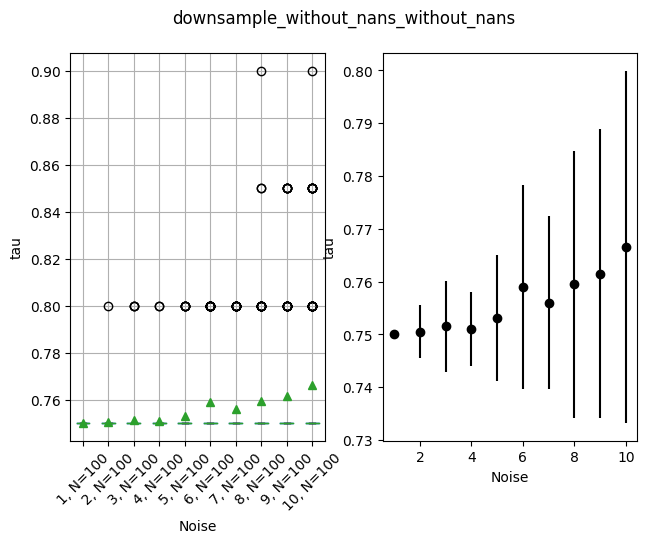

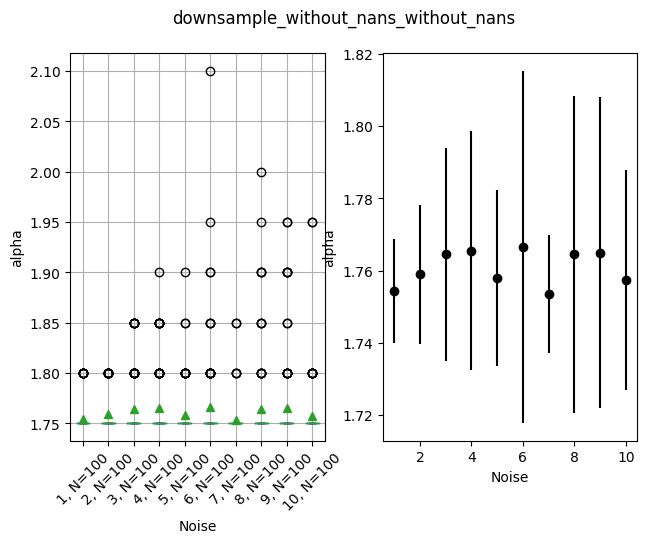

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.009580492597732; at
   delta   tau  alpha
1    1.0  0.75   1.75


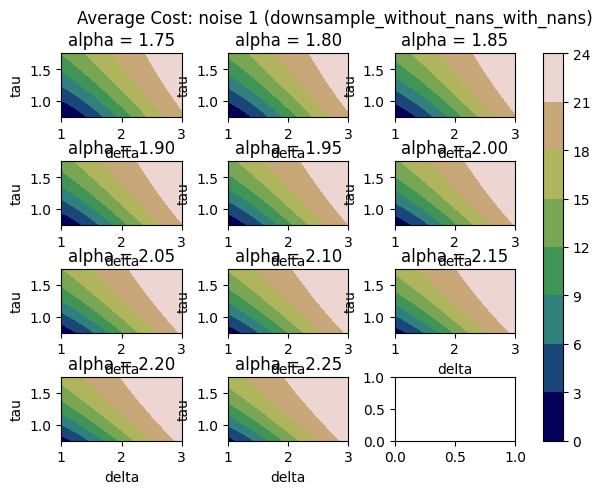

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.9863035536005498; at
   delta   tau  alpha
1    1.0  0.75   1.75


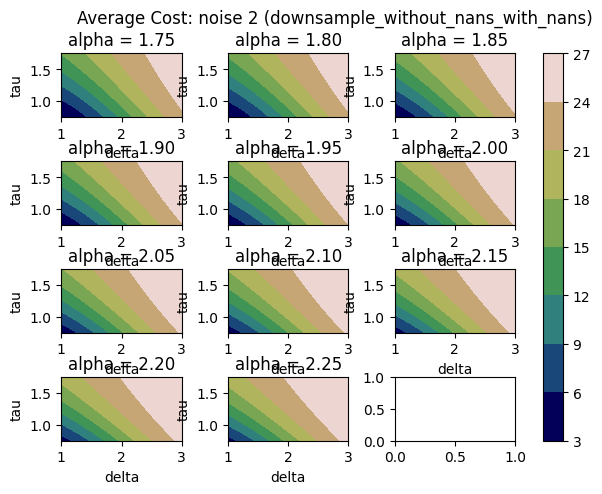

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.090980446435953; at
   delta   tau  alpha
1    1.0  0.75   1.75


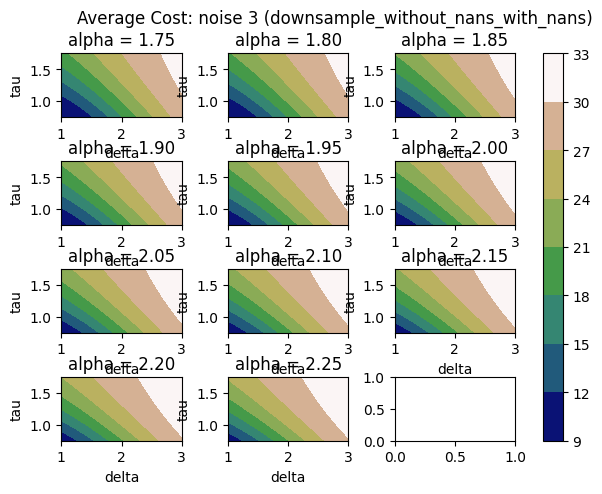

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.948057531492193; at
   delta   tau  alpha
1    1.0  0.75   1.75


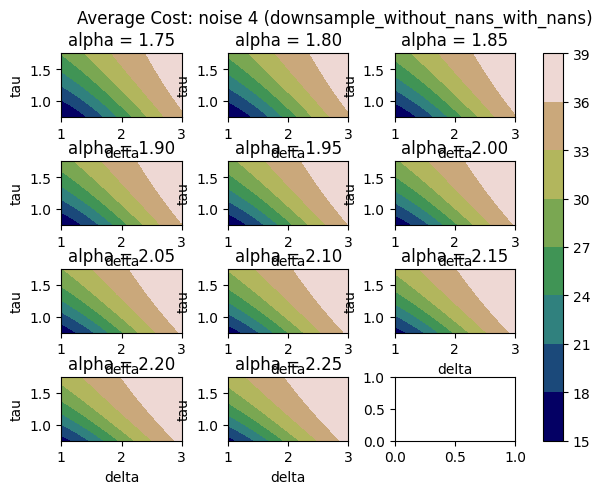

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.029148337397547; at
   delta   tau  alpha
1    1.0  0.75   1.75


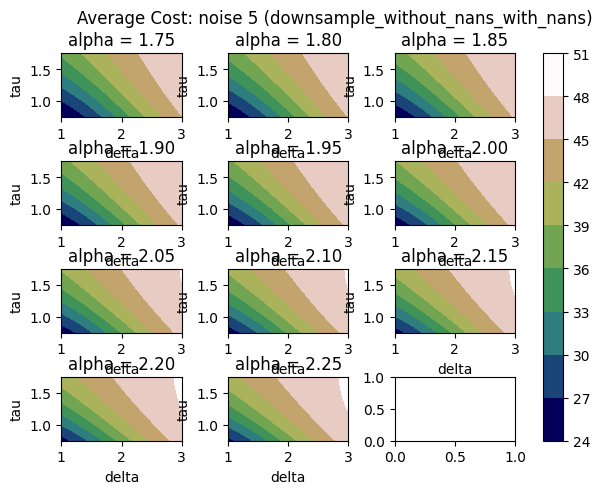

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.91011822522617; at
   delta   tau  alpha
1    1.0  0.75   1.75


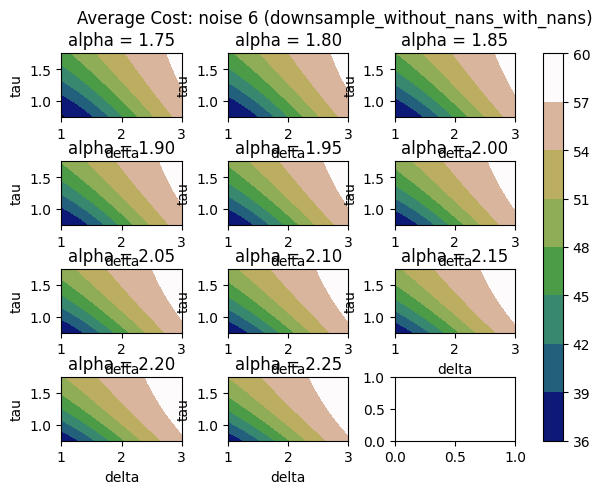

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.55148089461457; at
   delta   tau  alpha
1    1.0  0.75   1.75


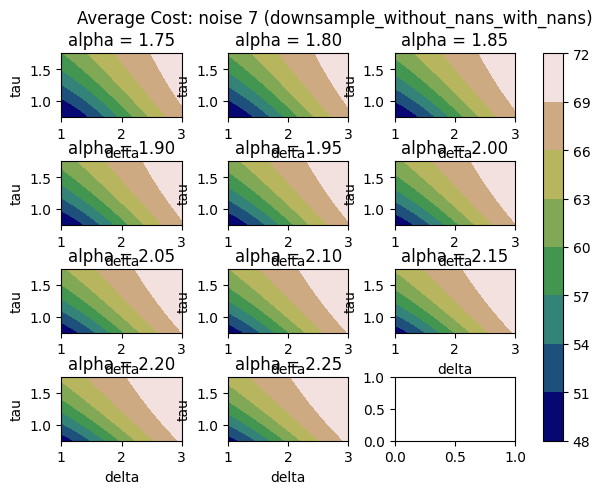

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.2163047737811; at
   delta   tau  alpha
1    1.0  0.75   1.75


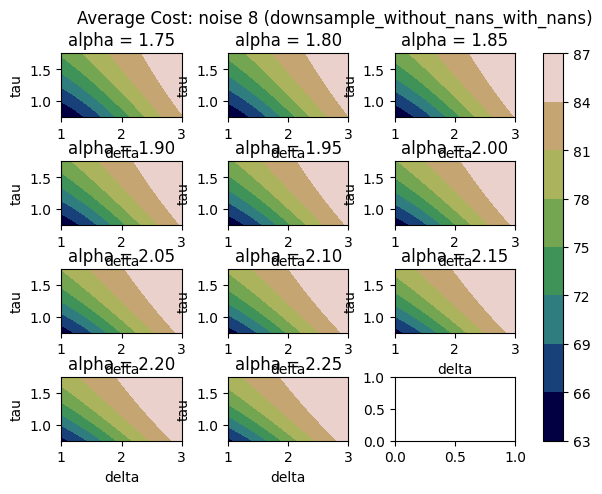

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.45266192171334; at
   delta   tau  alpha
1    1.0  0.75   1.75


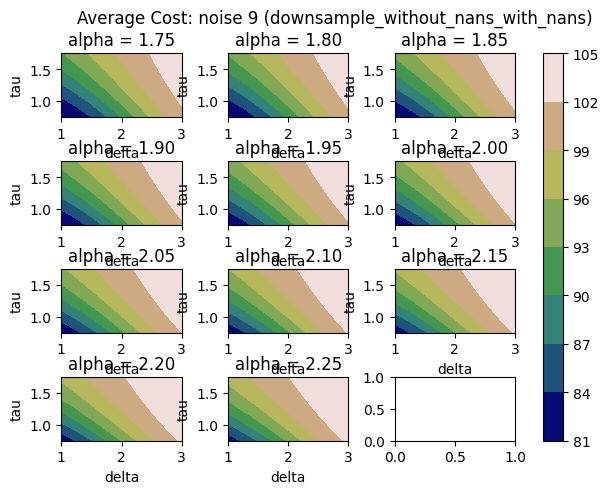

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.63200478202127; at
   delta   tau  alpha
1    1.0  0.75   1.75


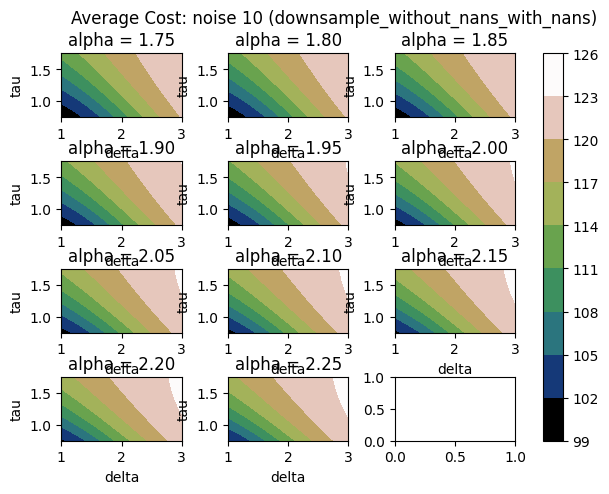

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


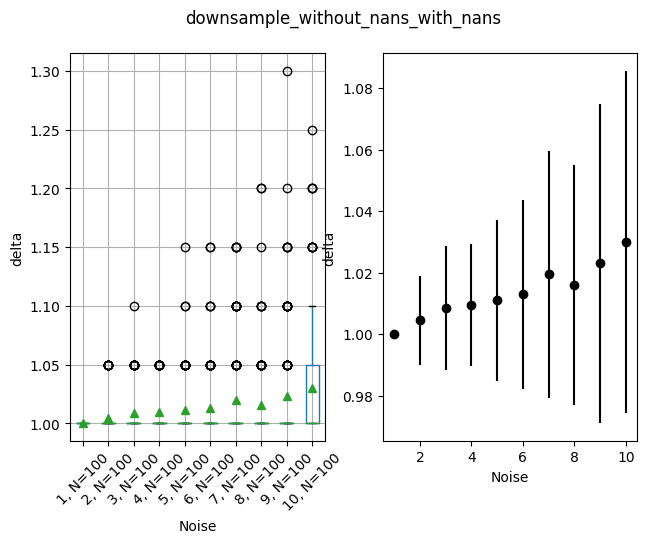

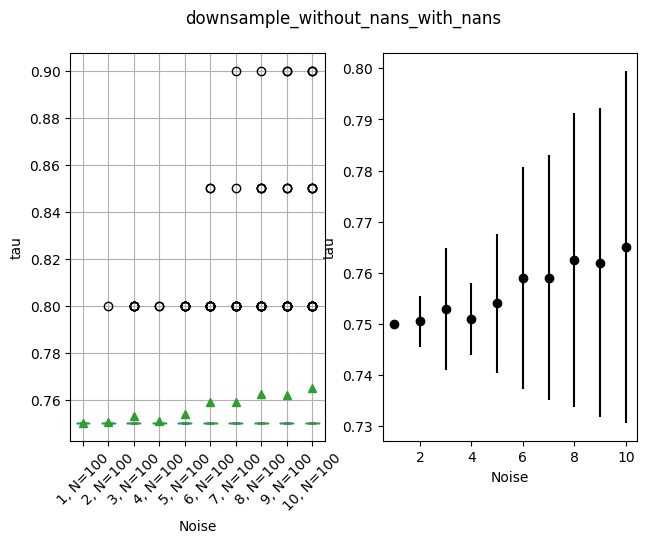

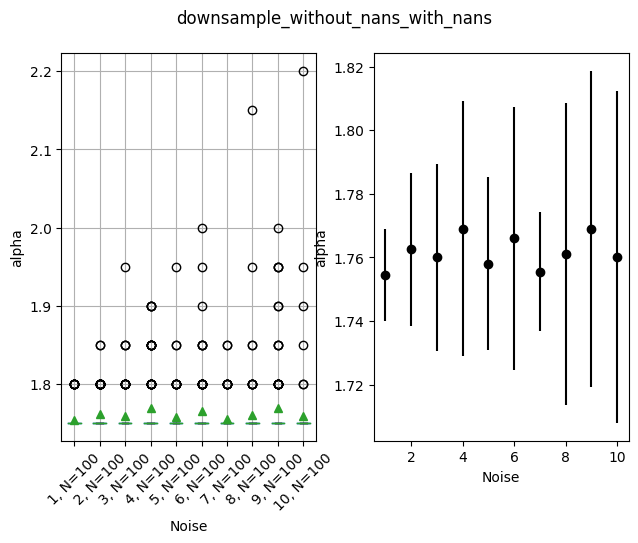

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau alpha
0         1         0    1.039613                 1.0  0.75  1.75
1         1         1    1.070662                 1.0  0.75  1.75
2         1         2    1.020251                 1.0  0.75  1.75
3         1         3    1.139824                 1.0  0.75  1.75
4         1         4    1.030288                 1.0  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1070     10        90  102.591298  1.1500000000000001  0.75  1.75
1071     10        87   98.260196  1.1500000000000001  0.75   1.8
1072     10        85   94.566126  1.1500000000000001   0.8  1.75
1073     10        44   92.125147  1.2000000000000002  0.75  1.75
1074     10        58  100.804020  1.2000000000000002  0.75  1.75

[1075 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
3                      100.0  1.06  0.238683  1.0  1.0  1.0  1.0  2.0
4                      100.0  1.07  0.256432  1.0  1.0  1.0  1.0  2.0
5                      100.0  1.05  0.219043  1.0  1.0  1.0  1.0  2.0
6                      100.0  1.10  0.333333  1.0  1.0  1.0  1.0  3.0
7                      100.0  1.08  0.272660  1.0  1.0  1.0  1.0  2.0
8                      100.0  1.13  0.393251  1.0  1.0  1.0  1.0  3.0
9                      100.0  1.13  0.418149  1.0  1.0  1.0  1.0  3.0
10                     100.0  1.13  0.366667  1.0  1.0  1.0  1.0  3.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau alpha
0         1         0    1.039613   1.0                0.75  1.75
1         1         1    1.070662   1.0                0.75  1.75
2         1         2    1.020251   1.0                0.75  1.75
3         1         3    1.139824   1.0                0.75  1.75
4         1         4    1.030288   1.0                0.75  1.75
...     ...       ...         ...   ...                 ...   ...
1043     10        55   95.015011   1.0  0.8500000000000001  1.75
1044     10        70  102.655246   1.0  0.8500000000000001  1.75
1045     10        74   96.456286   1.0  0.8500000000000001  1.75
1046     10        94  101.326862   1.0  0.8500000000000001  1.75
1047     10        79  103.985260   1.0  0.9000000000000001  1.75

[907 rows x 6 columns]

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau alpha
0         1         0    1.039613                 1.0  0.75  1.75
1         1         1    1.070662                 1.0  0.75  1.75
2         1         2    1.020251                 1.0  0.75  1.75
3         1         3    1.139824                 1.0  0.75  1.75
4         1         4    1.030288                 1.0  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1069     10        39  108.623386  1.1500000000000001  0.75  1.75
1070     10        90  102.591298  1.1500000000000001  0.75  1.75
1071     10        87   98.260196  1.1500000000000001  0.75   1.8
1073     10        44   92.125147  1.2000000000000002  0.75  1.75
1074     10        58  100.804020  1.2000000000000002  0.75  1.75

[956 rows x 6 columns]

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
0         1         0    1.039613                 1.0  0.75  1.75
1         1         1    1.070662                 1.0  0.75  1.75
2         1         2    1.020251                 1.0  0.75  1.75
3         1         3    1.139824                 1.0  0.75  1.75
4         1         4    1.030288                 1.0  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1069     10        39  108.623386  1.1500000000000001  0.75  1.75
1070     10        90  102.591298  1.1500000000000001  0.75  1.75
1072     10        85   94.566126  1.1500000000000001   0.8  1.75
1073     10        44   92.125147  1.2000000000000002  0.75  1.75
1074     10        58  100.804020  1.2000000000000002  0.75  1.75

[878 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                  
      count unique  top freq count unique   top freq
noise                                               
1        91      1  1.0   91    91      1  0.75   91
10       91      5  1.0   69    91      4  0.75   69
2        82      2  1.0   73    82      2  0.75   81
3        81      3  1.0   71    81      2  0.75   76
4        85      3  1.0   67    85      2  0.75   80
5        89      3  1.0   70    89      2  0.75   84
6        84      4  1.0   73    84      2  0.75   67
7        95      5  1.0   70    95      2  0.75   83
8        90      4  1.0   75    90      4  0.75   73
9        90      5  1.0   72    90      3  0.75   72

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

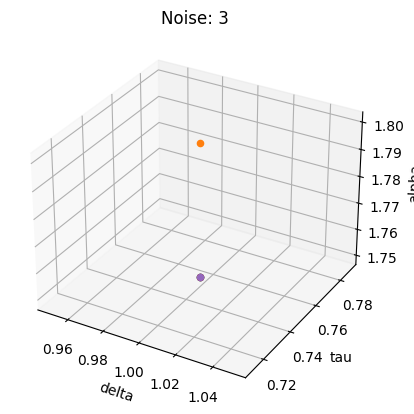

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

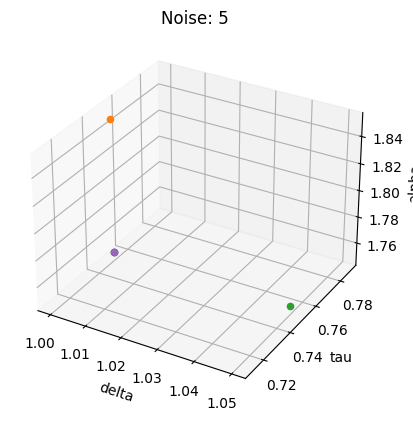

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

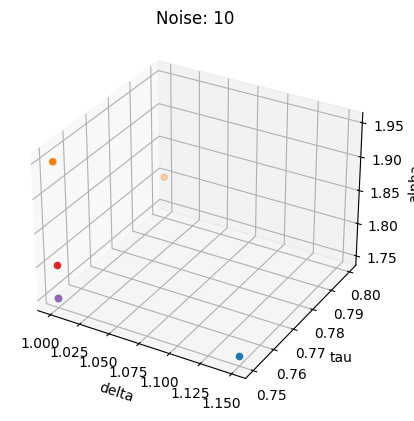

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau alpha
0         1         0    0.995156                 1.0  0.75  1.75
1         1         1    1.045074                 1.0  0.75  1.75
2         1         2    1.007459                 1.0  0.75  1.75
3         1         3    1.144761                 1.0  0.75  1.75
4         1         4    1.007812                 1.0  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1072     10        64  103.333370  1.1500000000000001  0.75  1.85
1073     10         0  101.195316  1.2000000000000002  0.75  1.75
1074     10        56  105.640485  1.2000000000000002  0.75  1.75
1075     10        90   98.530563  1.2000000000000002  0.75  1.75
1076     10        58  106.480796  1.2500000000000002  0.75  1.75

[1077 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.00  0.000000  1.0  1.0  1.0  1.0  1.0
2                      100.0  1.02  0.140705  1.0  1.0  1.0  1.0  2.0
3                      100.0  1.06  0.238683  1.0  1.0  1.0  1.0  2.0
4                      100.0  1.11  0.314466  1.0  1.0  1.0  1.0  2.0
5                      100.0  1.05  0.219043  1.0  1.0  1.0  1.0  2.0
6                      100.0  1.08  0.307482  1.0  1.0  1.0  1.0  3.0
7                      100.0  1.08  0.307482  1.0  1.0  1.0  1.0  3.0
8                      100.0  1.14  0.426875  1.0  1.0  1.0  1.0  4.0
9                      100.0  1.18  0.479478  1.0  1.0  1.0  1.0  4.0
10                     100.0  1.05  0.261116  1.0  1.0  1.0  1.0  3.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau alpha
0         1         0    0.995156   1.0                0.75  1.75
1         1         1    1.045074   1.0                0.75  1.75
2         1         2    1.007459   1.0                0.75  1.75
3         1         3    1.144761   1.0                0.75  1.75
4         1         4    1.007812   1.0                0.75  1.75
...     ...       ...         ...   ...                 ...   ...
1039     10        70  103.402093   1.0  0.8500000000000001  1.75
1040     10        94  100.844426   1.0  0.8500000000000001  1.75
1041     10        19  107.904240   1.0  0.9000000000000001  1.75
1042     10        79  101.023101   1.0  0.9000000000000001  1.75
1043     10        85   88.957312   1.0  0.9000000000000001  1.75

[871 rows x 6 columns]

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau alpha
0         1         0    0.995156                 1.0  0.75  1.75
1         1         1    1.045074                 1.0  0.75  1.75
2         1         2    1.007459                 1.0  0.75  1.75
3         1         3    1.144761                 1.0  0.75  1.75
4         1         4    1.007812                 1.0  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1072     10        64  103.333370  1.1500000000000001  0.75  1.85
1073     10         0  101.195316  1.2000000000000002  0.75  1.75
1074     10        56  105.640485  1.2000000000000002  0.75  1.75
1075     10        90   98.530563  1.2000000000000002  0.75  1.75
1076     10        58  106.480796  1.2500000000000002  0.75  1.75

[954 rows x 6 columns]

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
0         1         0    0.995156                 1.0  0.75  1.75
1         1         1    1.045074                 1.0  0.75  1.75
2         1         2    1.007459                 1.0  0.75  1.75
3         1         3    1.144761                 1.0  0.75  1.75
4         1         4    1.007812                 1.0  0.75  1.75
...     ...       ...         ...                 ...   ...   ...
1071     10        78   96.620994  1.1500000000000001  0.75  1.75
1073     10         0  101.195316  1.2000000000000002  0.75  1.75
1074     10        56  105.640485  1.2000000000000002  0.75  1.75
1075     10        90   98.530563  1.2000000000000002  0.75  1.75
1076     10        58  106.480796  1.2500000000000002  0.75  1.75

[878 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                  
      count unique  top freq count unique   top freq
noise                                               
1        91      1  1.0   91    91      1  0.75   91
10       95      6  1.0   66    95      4  0.75   75
2        79      2  1.0   68    79      2  0.75   78
3        88      3  1.0   70    88      2  0.75   81
4        84      2  1.0   64    84      2  0.75   79
5        90      4  1.0   72    90      2  0.75   83
6        83      4  1.0   67    83      3  0.75   67
7        91      4  1.0   71    91      4  0.75   79
8        92      5  1.0   70    92      4  0.75   76
9        85      6  1.0   65    85      4  0.75   70

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

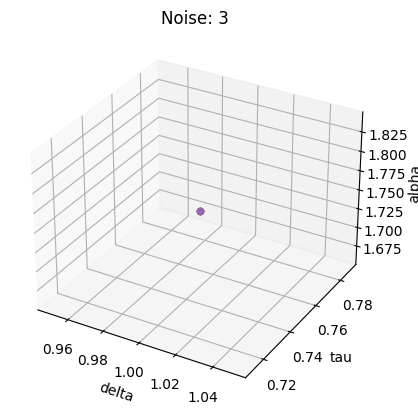

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

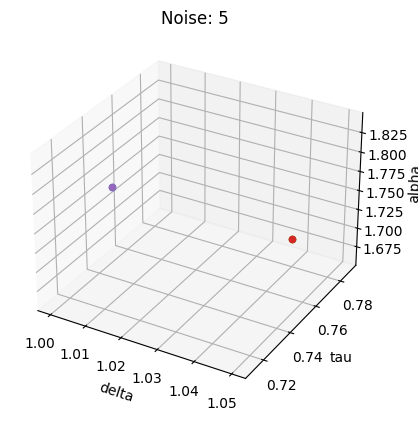

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

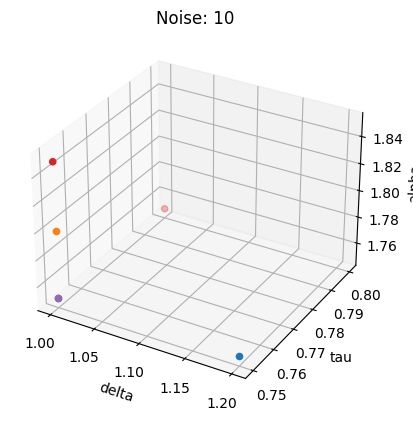

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()